# The latent space of colors

In Machine Learning, the concept of a latent vector space has wide ranging applications. From word vectors that are used in natural language processing to the hidden layers of a convolutional neural network used in face detection and image generation. 

What's a latent vector space? I couldn't find a nice pithy deffinition on the web. Here<https://hackernoon.com/latent-space-visualization-deep-learning-bits-2-bd09a46920df> is a pretty nice visual demonstation. I'll take a crack a deffintion here:

A latent vector space is a dimentionally reduced representation of an input that encodes meanful aspects of that input. A common example, word2vec, 

Let's break it down: a vector is a collection of numbers. In a vector space each number repersents a position along an independent axis. You can think of a vector pointing to a position, or a dot, in a multi-deminsion space. A latent vector space, is one in which the axis of the space and the state of the vectors isn't known. Latent is also used discribe things that are hidden but present.

With a latent vector space we are hoping to discover some shape or order to out data that is hidden, but present.


One way of understand the process of discovering these hidden qualities is to start with a vector space that we already know. This is where colors come in. Colors are usually repesented with a vector of 3 numbers, representing the values of red, green and blue. 

Usually tasks that involve a latent space are like a guessing game. Word2Vec an other work and sentence vectors are structured this way. In the bag-of-words model, a sentnce fragment is presented and one of the words is removed. The network tries to guess the missing word based on the words that are adjacent. 
https://iksinc.online/tag/continuous-bag-of-words-cbow/


https://blog.xkcd.com/2010/03/01/color-name-survey/
The web comic XKCD ran a survey in which participents were asked to enter a pain text name for colors as they were presented. The raw survey data is available and this is a great place to start with our color guessing game. 

The basic idea is this, first initalize a random vector of 3 numbers for each color value used in the survey. Then run each of our new random colors though a simple neural network and have it guess the original color. When the network is back propagated, then the network weights and the false color values are updated. The idea is that was the color vecotrs are updated to similar positions in the vector space, the color predictions will become more accurate. Once the proecess is complete, we should have new color map.

But a map of what?

Here are the posibilites:
1) The network doesn't train
2) The network trains but the results are non-senseical
3) The network trains and results in a preceptural color space that is understandable
4) The network trains and results in a color space that is a strange slice of some other understandable space
5) The network train and RGB values similar to the starting ones are present

My guess is that it will be #4. #5 seems like it's very unlikely.




Great article on color preception: http://jamie-wong.com/post/color/



In [ ]:
So far ive tried to train with a reduced color space, but it;s not training. Need to verify that the color space conversions are good
After trying to do the reducded color set, will try triplet color loss

In [3]:
import sqlite3
import pickle
import color_utils

# Color Embeddings

In [ ]:
#First download the raw data
!wget http://xkcd.com/color/colorsurvey.tar.gz

In [ ]:
#uncompress the .gz
!tar zxvf  colorsurvey.tar.gz

In [ ]:
#import the sql dump
!cat mainsurvey_sqldump.txt  | sqlite3 color_survey.db

In [4]:
#open the db

conn = sqlite3.connect('color_survey.db')
c = conn.cursor()

#fetch the common color names
c.execute("SELECT colorname from names where numusers > 500 group by colorname")
color_name_results = c.fetchall()

#replace all the alternate spelling and common synomyms
replacements = [("\'", ''),
                ('bluish','blueish'),
                ('blurple','bluish purple'),
                ('brick red','brick'),
                ('blood red','blood'),
                ('burgandy','burgundy'),
                ('cobalt blue','cobalt'),
                ('cornflower blue','cornflower'),
                ('olive green','olive'),
                ('forrest','forest'),
                ('forest green','forest'),
                ('fuchsia','fuchsia'),
                ('fuscia','fuchsia'),
                ('fushia','fuchsia'),
                ('grey', 'gray'),
                ('lavendar','lavender'),
                ('lavender','lavender'),
                ('lila','lilac'),
                ('mint green','mint'),
                ('moss green','moss'),
                ('navy blue','navy'),
                ('periwinkle blue','periwinkle'),
                ('perriwinkle','periwinkle'),
                ('pruple','purple'),
                ('sea foam green','seafoam'),
                ('turqouise','turquoise'),
                ('turquiose', 'turquoise'),
                ('turquise', 'turquoise'),
                ('turquoise', 'turquoise'),
                ('vomit green','vomit'),
                ('wine red','wine'),
                ('yello', 'yellow'),
                ('gross', ''),
                ('ugly',''),
                ("ish", ''),
                (' ', ''),
                ('-', '')
                ]

def fixColorString(color_name, replacements): 
    for item in replacements:
        color_name = color_name.replace(item[0],item[1])

    return color_name

#map the original color names to the cleanup ones
color_map = {}

for name in color_name_results:
    orignal_name = name[0]
    cleanedup_name = fixColorString(orignal_name, replacements)
    if cleanedup_name:
        color_map[orignal_name] = cleanedup_name
    

In [5]:
EMBEDDING_DIM = 3
colorname_value = []
total_colors = set()
c.execute("SELECT colorname, r,g,b from answers")
answers = c.fetchall()

start_bit_depth = 8
end_bit_depth = 2
devisor = int(2**start_bit_depth / 2**end_bit_depth)
for answer in answers:
    name = answer[0]
    if name in color_map:
        name = color_map[name]
        r = answer[1]
        g = answer[2]
        b = answer[3]
        color_value_8bit = color_utils.RGBToColorValue(r, g, b, start_bit_depth)
        color_value_2bit = color_utils.RGBToColorValue(r//devisor, g//devisor, b//devisor, end_bit_depth)
        total_colors.add(color_value_8bit)
        colorname_value.append((name, color_value_8bit, color_value_2bit))
 

In [6]:
color_file = open("colorname_value.pl",'wb') 
pickle.dump(colorname_value, color_file)
color_file.close()

# Visualize the color data
To make sure that something didn't get messed up and to get a better idea about our data, lets graph it.
First we will look at the 8bit colors as a cube

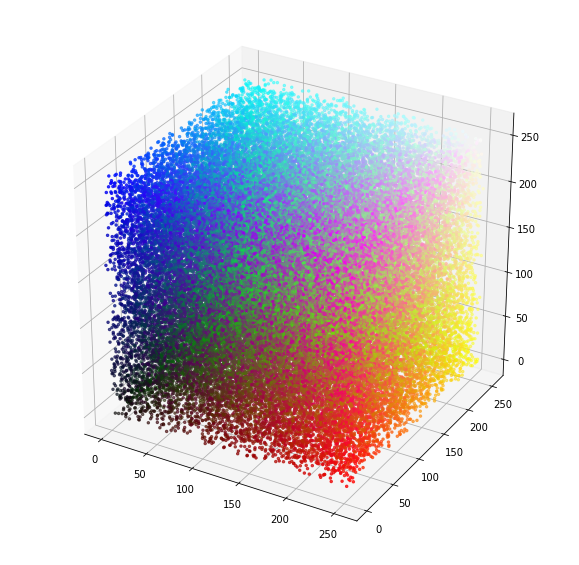

In [7]:
import ipympl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')

x = []
y = []
z = []
colors = []
for name, color8bit, _ in colorname_value[:60000]:
    r, g, b = color_utils.colorValueToRGB(color8bit, 8)
    colors.append((r/255.0,g/255.0,b/255.0))
    x.append(r)
    y.append(g)
    z.append(b)
    
ax.scatter(x, y, z, c=colors, s=6)
plt.show()


Next the 2 bit colors but using the 8 bit position values

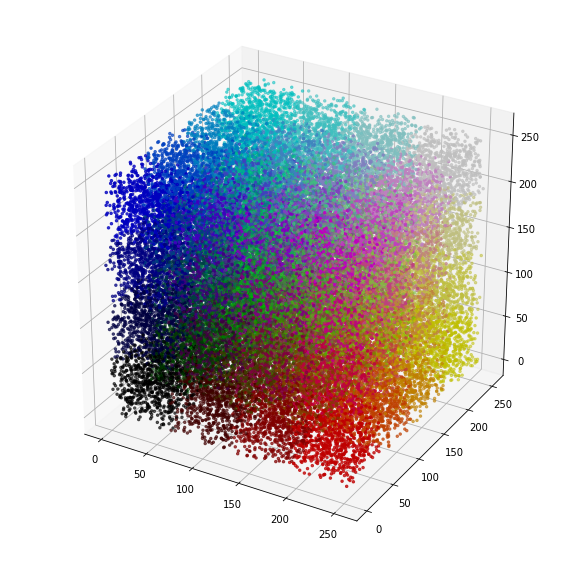

In [10]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')

x = []
y = []
z = []
colors = []
for name, color8bit, color2bit in colorname_value[:50000]:
    r, g, b = color_utils.colorValueToRGB(color2bit, 2)
    colors.append((r/4.0,g/4.0,b/4.0))
    r, g, b = color_utils.colorValueToRGB(color8bit, 8)
    x.append(r)
    y.append(g)
    z.append(b)
    
ax.scatter(x, y, z, c=colors, s=6)
plt.show()
